# Kernel regression

<a target="_blank" href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab-9.Kernel_Regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [169]:
import numpy as np
import matplotlib.pyplot as plt

## Linear data

First, we need some data we can play with. Let's create some arbitrary 2D samples.

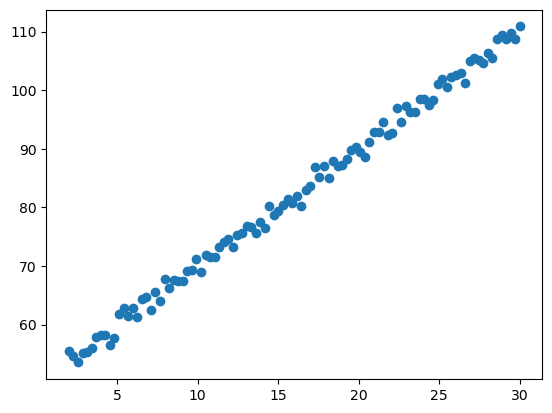

In [170]:
points = 100
sigma = 1

eps = np.random.normal(0,sigma,points)
x = np.linspace(2,30,points)
y = 2 * x + 50 + eps
x = x[:, np.newaxis]
plt.plot(x,y, 'o')

You can clearly see that there is a strong correlation between the two variables.

We know that the equation of a line is $y = wx$. Solving for $w$: $$w = X^{-1}y$$

Since we can not invert a matrix that isn’t square we simply make $X$ square by multiplying with its own transpose before inversion. To get the original shape back and by magic of math we multiply by the transpose again.
$$X^{-1} \sim (X^TX)^{-1} \, X^T$$
Plugging it in:
$$w=(X^{T}X)^{-1}\, X^{T} \, y$$

Dimensions: 
- $X\in R^{N\times d}$
- $X^{T}X\in R^{d\times d}$  

where $N$ is the number of points and $d$ is the dimension of each point.

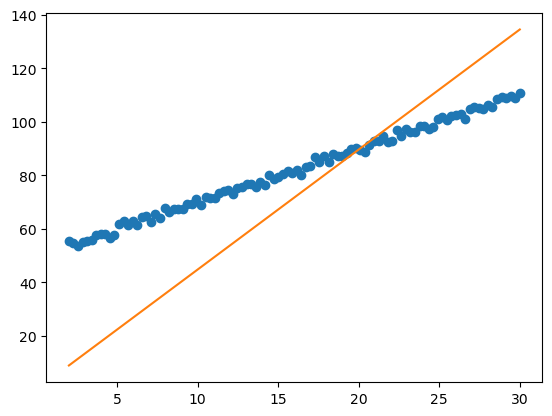

In [171]:
k = np.linalg.inv(np.dot(x.T, x))
w = np.dot(k, np.dot(x.T,y))
plt.plot(x,y,'o')
plt.plot(x, w*x)

Well we got a line, but it doesn’t really match the data yet. So what went wrong? The line equation that we started with $y=wx$ will always pass through $(0,0)$.

However, the regression line we expect from our data does not pass through $(0,0)$. So we have to adjust our line equation so that it’s y-value at $x=0$ can be fitted by our approach. We all know that we can simply add a constant to our line formula to end up with $y=wx+b$.

To deal with this situation, we just add an extra dimension to our data. Now the same multiplication of $X$ and $w$ will be $2$ dimensional as well. The matrix multiplication looks like this:

$$ \begin{bmatrix}
x_{0,0} \, w_0 + x_{0,1} \, w_1\\
\dots \\
x_{n,0} \, w_0 + x_{n,1} \, w_1
\end{bmatrix} = \begin{bmatrix}
y_0 \\ \dots \\ y_n
\end{bmatrix}
$$

Now if we set $x[:,1] = 1$ and we view $w[1]$ as $b$, we get the line equation with our bias. We don't even have to change our equations!

1. **Redo the calculations to add the constant $b$, then plot it.**  
*Tip: have a look at ```np.stack()```*

In [172]:
# before
x[:5]

array([[2.        ],
       [2.28282828],
       [2.56565657],
       [2.84848485],
       [3.13131313]])

$b = y - wx$

In [173]:
n = len(x)
n

100

In [174]:
# YOUR CODE
x = np.stack((x, np.ones([len(x), 1])), axis=-1).reshape(100, 2)

In [175]:
# after
x[:5]

array([[2.        , 1.        ],
       [2.28282828, 1.        ],
       [2.56565657, 1.        ],
       [2.84848485, 1.        ],
       [3.13131313, 1.        ]])

In [176]:
k = np.linalg.inv(np.dot(x.T, x))
w = np.dot(k, np.dot(x.T,y))

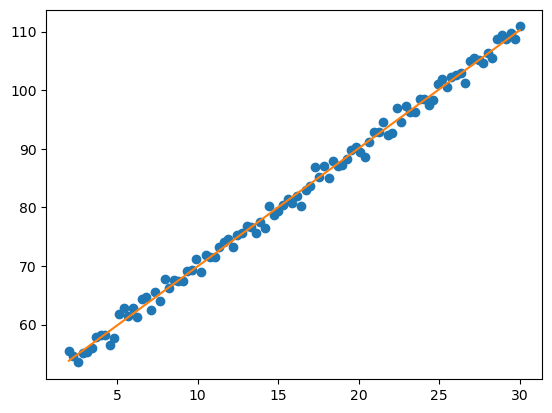

In [177]:
plt.plot(x[:,0], y, 'o')
plt.plot(x[:,0], x[:,0]*w[0] + w[1])

### Ridge regression
Sometimes the pseudo-inverse can run into trouble which can be avoided if we add a small value to our matrix before computing the inverse. This is known as *ridge regression*.


$$
w=(X^{T}X+\lambda \, I)^{-1}\, X^{T}y
$$

The effect is to mitigate the condition number of the matrix we are trying to invert. 

This is particularly important when we are dealing with a number of points which is $O(d)$ where $d$ is the number of dimensions (or parameters to estimate).
If this is the case it could happen that some rows or column are near to be **linearly dependent** and so the matrix cannot be inverted.
This is rarely the case, but the more the matrix approaches to be singular (determinant $\approx 0$) the worse the inverse we get.


## A note on numerical linear algebra

## NEVER DARE TO INVERT EXPLICITLY A MATRIX

Matrix inversion is an extremely expensive operation and it should be avoided at all costs since it is $O(n^3)$.
Usually the dimensions of the matrix we use scale with the number of points, or the number of parameters. 

Moreover, since we cannot be sure if our matrix is (approximately) singular, we can have huge and unreliable errors on the inverse.

More more over, if our starting matrix is *sparse*, so it contains a lot of zeros and can be stored efficiently in memory, it's inverse usually is *dense* so we end up consuming a lot of memory.

### What is the strategy?

If you are in a situation like the one above so something like 
$$
w=(X^{T}X+\lambda \, I)^{-1}\, X^{T}y
$$
The objective is to reframe it as the solution of a linear system.

$$(X^{T}X+\lambda \, I)w=X^{T} \, y$$


In [178]:
lam = 1
k = np.linalg.inv(np.dot(x.T,x) + lam * np.eye(x.shape[1]))
w_ridge = np.dot(k,np.dot(x.T,y))

#here below solve using the second strategy

w_ridge_no_inv = np.linalg.solve(x.T @ x + lam*np.identity(2), x.T @ y)


print(abs((w_ridge_no_inv - w_ridge)).max())

4.973799150320701e-14


In [179]:
w_ridge

array([ 2.12938423, 47.49747883])

In [180]:
w_ridge_no_inv

array([ 2.12938423, 47.49747883])

## Kernel Regression

What if our data isn't linear? (Rarely data is)

The entire framework of kernel regression revolves around of the idea of adding features explicitly or implicitly and getting into a space where our data is linearly separable.

Let's set up some non-linear data.

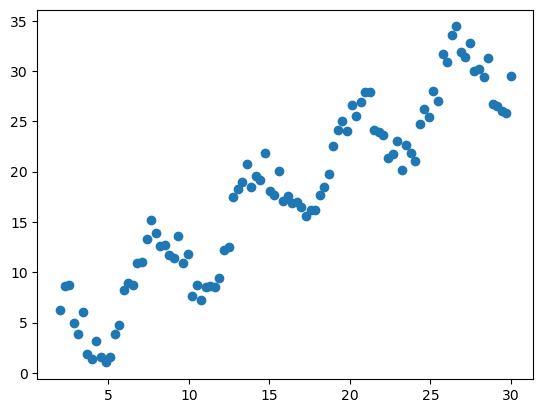

In [181]:
y= x[:,0] + 4 * np.sin(x[:,0])+ 4 * np.random.rand(x.shape[0])

plt.plot(x[:,0], y, 'o')

2. **Define the following kernel functions**
- Polynomial $$k(x_1,x_2) = (x_1^T \cdot x_2 +1 )^p $$
- Gaussian $$k(x_1, x_2) = \exp \bigg( - \frac{||x_1-x_2||^2}{2p^2} \bigg)$$
- Linear $$k(x_1,x_2) = x_1^T \cdot x_2 $$

Kernels must satisfy some requirements. 
A kernel function $K(x,y)$ is a function that can be written as the dot product of two vectors
$$ K(x,y) = < \phi(x) | \phi(y) >$$

By default a kernel should be *symmetric* $K(x,y) = K(y,x)$. The resulting matrix should be positive semidefinite

$\phi$ is called *feature map* and it is usually unknown. The space in which the vectors $\phi(.)$ live, is higher dimensionar w.r.t the one in which $x$ lives, possibly $\phi(x)$ is infinite dimensional.


In [182]:
from typing import Literal, Union

def poly(x, y, p):
    return (np.dot(x, y))**p

def gauss(x, y, p):
    return np.exp(-((np.linalg.norm(x-y)**2)/(2*p**2)))

def lin(x, y, p):
    return poly(x, y, 1)

def kernelFunc(x1, x2, kernel_type: Union[Literal["poly"], Literal["gauss"], Literal["lin"]], param):
    """
    args:
        x_1: first component, array
        x_2: second component, array
        kernel_type: used to specify which kernel to use, string
        param: p parameter
    
    output:
        Value of the kernel 
    """
    hash_funcs = {'poly': poly, 'gauss': gauss, 'lin': lin}
    phi = hash_funcs[kernel_type]

    return phi(x1,x2, param).T * phi(x1,x2, param)


$$
K_{i,j} = K(x_i, x_j)
$$

In [183]:
# YOUR CODE - Compute K matrix
my_type = 'gauss'
my_p = 2.5

K = np.zeros((n , n))

for i in range(n):
    for j in range(n):
        K[i,j] = kernelFunc(x[i, 0], x[j, 0], my_type, my_p)

K.T + K == 2*K # Verify if K is symmetric

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Before going on, notice how $$w = (X^TX + \lambda I )^{-1} X^Ty$$ 

is the same as 
$$w=X^T(XX^T  + \lambda I)^{-1}y.$$ 
This is needed since our kernel matrix is $n$ x $n$


Now we just take our linear regression and replace all dot products with kernel functions.

Assume we want to compute the value $y$ of an unknown observation $z$, by ignoring for a moment the regularization
$$
y(z)=z^Tw=z^T \, X^{T}(XX^{T})^{-1} \ y 
$$

The kernel should substitute dot product where they appear
$$
y(z) = \phi(z)^T \phi(X^T) (\phi(X)\phi(X^T))^{-1} \, y
$$
$$
y(z) = \alpha(z)  \, K^{-1} \, y
$$

with $$\alpha(z)= \begin{bmatrix}
k(z,x_0) \\ \dots \\ k(z,x_N) 
\end{bmatrix} \in R^{1\times N} $$

The Kernel matrix here is $K=XX^{T}\in R^{N\times N}$, where $N$ is the number of points.

Notice that we also have to embed the vector at which we evaluate the regression, here $z$. Putting this into code we get:


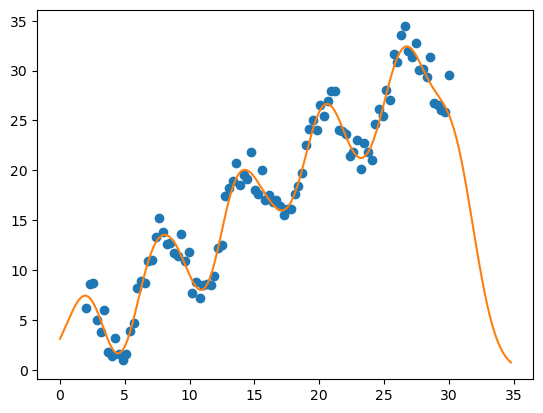

In [184]:
# calculate the inverse of K with ridge regression, then the weights
a = np.linalg.inv(K + 0.1 * np.eye(K.shape[0]))
w = np.dot(y,a)

x_pred = np.arange(0, 35, 0.2)
# same as before, add column of ones to represent the constant b
x_pred = np.stack([x_pred, np.ones(x_pred.shape[0])], axis=1).reshape(-1,2)
y_pred = np.zeros(x_pred.shape[0])

for i, x_p in enumerate(x_pred):
    k = np.zeros(x.shape[0])
    for j, row in enumerate(k):
        k[j] = kernelFunc(x_p, x[j,:], my_type, my_p)
    y_pred[i] = np.dot(w,k)

plt.plot(x[:,0], y, 'o')
plt.plot(x_pred[:,0], y_pred)

## Putting all together

This function performs Kernel Ridge Regression (KRR) from scratch (S) on a given training dataset and uses the resulting model to predict the labels of a given test dataset.

The inputs to the function are:

- X_train: a numpy array representing the training data.
- y_train: a numpy array representing the target variable for the training data.
- X_test: a numpy array representing the test data.
- kernel_type: a string indicating the type of kernel to be used. 
- param: the parameter to be used in the kernel function.
- lam: a scalar indicating the regularization parameter for the KRR model.

The function first computes the kernel matrix $K$ using the training data and the kernel function specified by kernel_type and param. It then applies ridge regression to the kernel matrix to calculate the weights. Finally, it computes the predicted target values for the test data using the kernel function and the learned weights. The predicted labels are returned as an array.

3. **Write this function.**

In [185]:
def KRRS(X_train, y_train, X_test, kernel_type, param, lam):
    """
    args:
        X_train: train set, matrix
        y_train: labels for training, array
        X_test: test set, matrix
        kernel_type: used to specify which kernel to use, string
        param: p parameter
        lam: lambda parameter used in RR
    
    output:
        Predictions for the test set
    """
    n = len(X_train)

    # Calculate K on train set
    K = np.zeros((n , n))

    for i in range(n):
        for j in range(n):
            K[i,j] = kernelFunc(X_train[i, 0], X_train[j, 0], kernel_type, param)

    # calculate the inverse of K with ridge regression, then the weights
    a = np.linalg.inv(K + lam * np.eye(K.shape[0]))
    w = np.dot(y_train, a)

    # make predictions!!! :D
    return X_test[:, 0]*w[0] + w[1]

In [186]:
KRRS(x_pred, y_pred, x_pred, 'lin', 5, 1)

array([  3.676171  ,   4.29978548,   4.92339997,   5.54701446,
         6.17062894,   6.79424343,   7.41785791,   8.0414724 ,
         8.66508688,   9.28870137,   9.91231585,  10.53593034,
        11.15954483,  11.78315931,  12.4067738 ,  13.03038828,
        13.65400277,  14.27761725,  14.90123174,  15.52484622,
        16.14846071,  16.7720752 ,  17.39568968,  18.01930417,
        18.64291865,  19.26653314,  19.89014762,  20.51376211,
        21.1373766 ,  21.76099108,  22.38460557,  23.00822005,
        23.63183454,  24.25544902,  24.87906351,  25.50267799,
        26.12629248,  26.74990697,  27.37352145,  27.99713594,
        28.62075042,  29.24436491,  29.86797939,  30.49159388,
        31.11520836,  31.73882285,  32.36243734,  32.98605182,
        33.60966631,  34.23328079,  34.85689528,  35.48050976,
        36.10412425,  36.72773874,  37.35135322,  37.97496771,
        38.59858219,  39.22219668,  39.84581116,  40.46942565,
        41.09304013,  41.71665462,  42.34026911,  42.96

### Pre-made functions for KRR
- always [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

In [187]:
from sklearn.kernel_ridge import KernelRidge

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
krr = KernelRidge(alpha=1.0, kernel = 'rbf') # other options: linear, polynomial, exponential, laplacian, chi2, sigmoid
krr.fit(x_pred, y_pred)
krr.predict(x_pred)

array([ 2.83889814,  3.37996414,  3.93839047,  4.49607011,  5.03322152,
        5.52917737,  5.96320471,  6.31540559,  6.56774868,  6.70524705,
        6.71723538,  6.59863503,  6.35104798,  5.98350569,  5.51271977,
        4.96273321,  4.36393948,  3.7515118 ,  3.16335165,  2.63771871,
        2.2107376 ,  1.91399028,  1.77239567,  1.80255306,  2.01168477,
        2.39726063,  2.94732614,  3.64149383,  4.45249793,  5.34816345,
        6.29360639,  7.25346576,  8.19397398,  9.08469731,  9.89982221,
       10.61891989, 11.22718411, 11.71519936, 12.07834842, 12.31600539,
       12.43067576, 12.42723756, 12.31240785, 12.09451009, 11.78355756,
       11.39160389, 10.93325465, 10.42619078,  9.89153531,  9.35390082,
        8.84098939,  8.38267381,  8.00956276,  7.75113259,  7.633583  ,
        7.67763206,  7.89649813,  8.29431613,  8.86520226,  9.59311701,
       10.45259   , 11.41027153, 12.42717955, 13.46142833, 14.47116935,
       15.41745199, 16.26672562, 16.9927531 , 17.57778097, 18.01

## BONUS

Weather data, try to predict using kernel regression the temperature of successive days, use a train/test split like before

In [188]:
import pandas as pd
df = pd.read_csv("./data/weather_data.csv")

In [189]:
df.head()


,_time,stationId,airHumidity,airPressure,airTemperature,batteryV,solarV
0,2025-03-01T23:00:41+00:00,esp_outdoor,67.50,102903.91,5.99,3.97,0.00
1,2025-03-01T23:10:40+00:00,esp_outdoor,67.61,102916.12,5.96,4.02,0.01
2,2025-03-01T23:20:42+00:00,esp_outdoor,67.94,102904.33,5.83,3.95,0.00
3,2025-03-01T23:30:44+00:00,esp_outdoor,65.33,102915.70,6.47,3.95,0.00
4,2025-03-01T23:40:40+00:00,esp_outdoor,63.60,102917.73,6.70,4.02,0.01


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _time           861 non-null    object 
 1   stationId       861 non-null    object 
 2   airHumidity     861 non-null    float64
 3   airPressure     861 non-null    float64
 4   airTemperature  861 non-null    float64
 5   batteryV        861 non-null    float64
 6   solarV          861 non-null    float64
dtypes: float64(5), object(2)
memory usage: 47.2+ KB


In [191]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(df, x = "_time", y = "airTemperature")
fig.update_layout(template = "plotly_white")


In [192]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = df["_time"], y = df["airTemperature"]), secondary_y = False
)

fig.add_trace(
    go.Scatter(x = df["_time"], y = df["solarV"]), secondary_y = True
)

fig.update_layout(template = "plotly_white")

In [193]:
df.describe()

,airHumidity,airPressure,airTemperature,batteryV,solarV
count,861.000000,861.000000,861.000000,861.000000,861.000000
mean,63.623391,102718.310616,9.570894,4.002369,2.112636
std,21.893811,262.533880,5.172550,0.035430,2.093457
min,26.920000,102015.170000,1.490000,3.820000,0.000000
25%,41.600000,102628.380000,4.690000,3.970000,0.010000
50%,68.730000,102738.140000,8.690000,4.010000,1.490000
75%,80.590000,102887.700000,14.410000,4.030000,4.180000
max,100.000000,103144.470000,20.570000,4.120000,4.700000


In [387]:
# Scale variables, just in case...
from sklearn.preprocessing import StandardScaler
numericals = df.drop(columns=['airTemperature']).select_dtypes(exclude='O').columns.tolist()

df_scaled = df.copy()

scaler = StandardScaler()
df_scaled[numericals] = scaler.fit_transform(df_scaled[numericals])

df_scaled = df_scaled.drop(columns=['stationId'])

df_scaled['_time'] = pd.to_datetime(df_scaled['_time'])

df_scaled['hour'] = df_scaled['_time'].dt.hour
df_scaled['minute'] = df_scaled['_time'].dt.minute
df_scaled['seconds'] = df_scaled['_time'].dt.second

df_scaled = df_scaled.drop(columns='_time')

In [388]:
X = df_scaled.drop(columns='airTemperature')
y = df_scaled['airTemperature']

In [389]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = df["_time"], y = y), secondary_y = False
)

fig.add_trace(
    go.Scatter(x = df["_time"], y = X['airHumidity']), secondary_y = True
)

fig.update_layout(template = "plotly_white")

In [439]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.feature_selection import SequentialFeatureSelector

rfer = SequentialFeatureSelector(KernelRidge(alpha=1, kernel='rbf', gamma = 0.01),
             cv = TimeSeriesSplit(),
             direction='backward',
             )

rfer.fit(X, y)

rfer.support_

array([ True,  True, False,  True,  True, False, False])

In [464]:
# Exhaustive Feature Search
from itertools import chain, combinations
from tqdm import notebook
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

KR = KernelRidge(alpha=1, kernel='rbf', gamma = 0.01)

best_r2 = -100
for combo in notebook.tqdm(powerset(X.columns.tolist())):
    if combo == ():
        continue

    list_combo = list(combo)
    r2_scores = []
    for train_idx, test_idx in TimeSeriesSplit().split(X, y):
        X_train = X[list_combo].iloc[train_idx]
        X_test = X[list_combo].iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        # Fit model on train
        KR.fit(X_train, y_train)

        # Predict on test set
        r2_scores.append(KR.score(X_test, y_test))

    mean_r2 = np.mean(r2_scores)
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        print("Better combination found:", combo, "with score", mean_r2)
    

0it [00:00, ?it/s]

Better combination found: ('airHumidity',) with score 0.6234010894177062
Better combination found: ('hour',) with score 0.8470305328961849
Better combination found: ('airHumidity', 'hour') with score 0.8792375158733371
Better combination found: ('airHumidity', 'airPressure', 'hour') with score 0.887186570224417
Better combination found: ('airHumidity', 'airPressure', 'batteryV', 'hour') with score 0.8878452990624593
Better combination found: ('airHumidity', 'airPressure', 'solarV', 'hour') with score 0.8898289300190882
Better combination found: ('airHumidity', 'airPressure', 'batteryV', 'solarV', 'hour') with score 0.8902322283612196


In [ ]:
# Feature Selection
X_selected = X[['airHumidity', 'airPressure', 'batteryV', 'solarV', 'hour']].copy() # Selected features


In [441]:

# Fit and evaluate using time series splits
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

my_folds = TimeSeriesSplit(5)
KR = KernelRidge(alpha=1, kernel='rbf', gamma = 0.01)

# options: {'chi2', 'additive_chi2', 'linear', 'cosine', 'laplacian', 'rbf', 'precomputed', 'poly', 'polynomial', 'sigmoid'}

r2_scores = []
MSE_scores = []
for train_idx, test_idx in my_folds.split(X_selected, y):
    X_train = X_selected.iloc[train_idx]
    X_test = X_selected.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Fit model on train
    KR.fit(X_train, y_train)

    # Predict on test set
    r2_scores.append(KR.score(X_test, y_test))
    MSE_scores.append(mean_squared_error(y_test, KR.predict(X_test)))

display(np.mean(MSE_scores))
display(np.mean(r2_scores))

del r2_scores
del MSE_scores

3.2594142617394155

0.8898289300190882

In [442]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = df["_time"], y = y, name='Actual Values'), secondary_y = False
)

fig.add_trace(
    go.Scatter(x = df["_time"], y = KR.predict(X_selected), name='Predicted Values'), secondary_y = False
)


In [450]:
 # Hyperparameter optimization with RandomSearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint

param_dist = {
    'alpha': loguniform(1e-3, 1e3),
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'gamma': loguniform(1e-3, 1e3),
    'degree': randint(2, 6),     # Only used for 'poly'
    'coef0': uniform(0, 1)       # Only used for 'poly' and 'sigmoid'
}


kr = KernelRidge()
search = RandomizedSearchCV(kr, param_distributions=param_dist, n_iter=5000, cv=my_folds, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning:

Singular matrix in solving dual problem. Using least-squares solution instead.

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning:

Singular matrix in solving dual problem. Using least-squares solution instead.

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning:

Singular matrix in solving dual problem. Using least-squares solution instead.

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning:

Singular matrix in solving dual problem. Using least-squares solution instead.

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning:

Singular matrix in solving dual problem. Using least-squares solution instead.

c:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning:

Singular matrix in solving dual problem. Using l

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=KernelRidge(), n_iter=5000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D984487E60>,
                                        'coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D986095E50>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D9860964B0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D986096E10>,
                                        'kernel': ['rbf', 'poly', 'sigmoid',
                                                   'linear']},
                   verbose=1)

In [451]:
search.best_estimator_

KernelRidge(alpha=0.3920549684693931, coef0=0.02352698864143221, degree=2,
            gamma=0.02513188412588354, kernel='rbf')

In [455]:
best = KernelRidge(alpha=0.3920549684693931, coef0=0.02352698864143221, degree=2,
            gamma=0.02513188412588354, kernel='rbf')

r2_scores = []
MSE_scores = []
for train_idx, test_idx in my_folds.split(X_selected, y):
    X_train = X_selected.iloc[train_idx]
    X_test = X_selected.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Fit model on train
    best.fit(X_train, y_train)

    # Predict on test set
    r2_scores.append(KR.score(X_test, y_test))
    MSE_scores.append(mean_squared_error(y_test, KR.predict(X_test)))

display(np.mean(MSE_scores))
display(np.mean(r2_scores))

del r2_scores
del MSE_scores

1.2252245189060673

0.9585040075341326

In [456]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = df["_time"], y = y, name='Actual Values'), secondary_y = False
)

fig.add_trace(
    go.Scatter(x = df["_time"], y = best.predict(X_selected), name='Predicted Values'), secondary_y = False
)
